## Imports

In [1]:
import os
import re
import sys
import typing
import gc
import pandas as pd
import pickle
import logging

sys.path.append(
    os.path.join('.','src')
)

from src.models import Pipeline

In [2]:
logging.basicConfig(filename='logs/logs.log', level=logging.DEBUG)

# Tweets Model

In [3]:
pipeline = Pipeline('CONFIG_MODEL_TWEETS.json', load_model_data = True)

100%|██████████| 20000/20000 [00:02<00:00, 9336.16it/s]


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [4]:
pipeline.evaluate()

100%|██████████| 6166/6166 [00:09<00:00, 646.91it/s]


9.208185943890577

In [5]:
pipeline.perplexity()

100%|██████████| 6166/6166 [00:19<00:00, 324.21it/s]


9977.921492731602

  0%|          | 7/15349 [00:00<03:41, 69.20it/s]

Train loss at epoch 0 : 9.208240880959352
Eval loss at epoch 0 : 9.208049606891127
updating best metric


 65%|██████▌   | 10024/15349 [01:14<00:38, 136.56it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1048576.0


 78%|███████▊  | 12026/15349 [01:29<00:24, 134.84it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1048576.0


 80%|███████▉  | 12222/15349 [01:30<00:22, 136.05it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 98%|█████████▊| 15036/15349 [01:51<00:02, 134.18it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  0%|          | 12/15349 [00:00<02:08, 119.57it/s]

Train loss at epoch 1 : 5.178810049869454
Eval loss at epoch 1 : 4.561475605872071
updating best metric


 17%|█▋        | 2644/15349 [00:19<01:33, 135.93it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 31%|███       | 4786/15349 [00:35<01:17, 136.01it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 45%|████▍     | 6874/15349 [00:51<01:03, 134.12it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 58%|█████▊    | 8904/15349 [01:06<00:48, 133.93it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 77%|███████▋  | 11746/15349 [01:27<00:26, 135.96it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 90%|█████████ | 13818/15349 [01:42<00:11, 135.20it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  0%|          | 0/15349 [00:00<?, ?it/s]

Train loss at epoch 2 : 4.42450630831807
Eval loss at epoch 2 : 4.2968381493608545
updating best metric


  3%|▎         | 503/15349 [00:03<01:50, 134.41it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  7%|▋         | 1119/15349 [00:08<01:46, 134.20it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 33%|███▎      | 5121/15349 [00:37<01:15, 135.74it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 46%|████▋     | 7137/15349 [00:53<01:00, 135.91it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 60%|█████▉    | 9139/15349 [01:07<00:45, 136.44it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 73%|███████▎  | 11225/15349 [01:23<00:30, 133.95it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 86%|████████▌ | 13227/15349 [01:38<00:15, 135.12it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 99%|█████████▉| 15271/15349 [01:53<00:00, 133.96it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  0%|          | 0/15349 [00:00<?, ?it/s]

Train loss at epoch 3 : 4.211570579288479
Eval loss at epoch 3 : 4.177562946486241
updating best metric


 13%|█▎        | 1973/15349 [00:14<01:38, 135.92it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 26%|██▌       | 4003/15349 [00:29<01:23, 135.96it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 39%|███▉      | 6005/15349 [00:44<01:09, 134.76it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 52%|█████▏    | 8023/15349 [00:59<00:53, 135.90it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 65%|██████▌   | 10039/15349 [01:14<00:38, 136.45it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 72%|███████▏  | 11033/15349 [01:21<00:31, 136.01it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 98%|█████████▊| 15037/15349 [01:51<00:02, 135.13it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  0%|          | 0/15349 [00:00<?, ?it/s]

Train loss at epoch 4 : 4.083906487429427
Eval loss at epoch 4 : 4.0976974798251895
updating best metric


 11%|█         | 1717/15349 [00:12<01:40, 136.28it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 24%|██▍       | 3719/15349 [00:27<01:25, 136.36it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 37%|███▋      | 5721/15349 [00:42<01:10, 135.71it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 50%|█████     | 7723/15349 [00:57<00:56, 135.62it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 56%|█████▌    | 8563/15349 [01:03<00:50, 134.70it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 82%|████████▏ | 12581/15349 [01:33<00:20, 134.70it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 95%|█████████▌| 14583/15349 [01:48<00:05, 133.47it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  0%|          | 0/15349 [00:00<?, ?it/s]

Train loss at epoch 5 : 3.9946491738873684
Eval loss at epoch 5 : 4.041332117677892
updating best metric


  8%|▊         | 1230/15349 [00:09<01:43, 136.21it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 16%|█▌        | 2462/15349 [00:18<01:36, 133.55it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 42%|████▏     | 6466/15349 [00:48<01:06, 132.77it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 55%|█████▌    | 8471/15349 [01:03<00:51, 134.29it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 60%|██████    | 9255/15349 [01:08<00:44, 135.75it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 86%|████████▋ | 13245/15349 [01:38<00:15, 135.01it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 99%|█████████▉| 15261/15349 [01:53<00:00, 134.68it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  0%|          | 0/15349 [00:00<?, ?it/s]

Train loss at epoch 6 : 3.9241355498284887
Eval loss at epoch 6 : 3.998693219434868
updating best metric


 12%|█▏        | 1907/15349 [00:14<01:40, 134.30it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 25%|██▌       | 3909/15349 [00:29<01:24, 135.26it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 39%|███▊      | 5911/15349 [00:44<01:09, 135.19it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 52%|█████▏    | 7911/15349 [00:59<00:55, 134.59it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 65%|██████▍   | 9913/15349 [01:14<00:40, 135.00it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 78%|███████▊  | 11929/15349 [01:29<00:25, 135.37it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 91%|█████████ | 13931/15349 [01:44<00:10, 135.01it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  0%|          | 0/15349 [00:00<?, ?it/s]

Train loss at epoch 7 : 3.867414220652057
Eval loss at epoch 7 : 3.967688408368614
updating best metric


  4%|▍         | 583/15349 [00:04<01:49, 134.84it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 17%|█▋        | 2585/15349 [00:19<01:34, 134.55it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 28%|██▊       | 4293/15349 [00:32<01:22, 134.56it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 54%|█████▍    | 8301/15349 [01:02<00:52, 134.70it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 67%|██████▋   | 10317/15349 [01:17<00:37, 134.92it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 69%|██████▉   | 10639/15349 [01:19<00:35, 134.37it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 88%|████████▊ | 13551/15349 [01:41<00:13, 132.80it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


  0%|          | 9/15349 [00:00<02:51, 89.23it/s]

Train loss at epoch 8 : 3.8178133709639304
Eval loss at epoch 8 : 3.933647334421337
updating best metric


 14%|█▍        | 2207/15349 [00:16<01:37, 134.75it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 20%|█▉        | 3033/15349 [00:22<01:32, 133.35it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 46%|████▌     | 7037/15349 [00:52<01:01, 135.35it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 55%|█████▌    | 8470/15349 [01:03<00:53, 128.91it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 75%|███████▍  | 11462/15349 [01:25<00:28, 134.19it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


100%|██████████| 1545/1545 [00:03<00:00, 418.90it/s]


Train loss at epoch 9 : 3.7741699025983397
Eval loss at epoch 9 : 3.9111770038080063
updating best metric


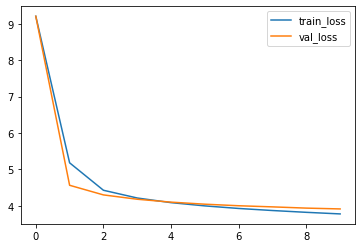

In [6]:
pipeline.train_model()

In [7]:
pipeline.evaluate()

100%|██████████| 6166/6166 [00:09<00:00, 635.59it/s]


3.964269939215538

In [8]:
pipeline.perplexity()

100%|██████████| 6166/6166 [00:19<00:00, 315.15it/s]


51.24621701062515

In [15]:
pipeline = Pipeline('CONFIG_MODEL_TWEETS.json', load_model_data = True)
pipeline.load_model('models/tweets/tweets.pth')

100%|██████████| 20000/20000 [00:02<00:00, 7812.66it/s]


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [16]:
pipeline.evaluate()

100%|██████████| 6166/6166 [00:09<00:00, 627.55it/s]


3.9642699436875777

In [17]:
pipeline.perplexity()

100%|██████████| 6166/6166 [00:20<00:00, 304.96it/s]


51.24621701062515

In [6]:
pipeline.generate(start_text = 'trump')

'trump rally ocala fl crowd at nevada rally so florida next the maga stepped pence audience thune maga trump again oh nc maga trump trump maga you its like hitler one move here is one of the debates debate at next debate debates debates debates debate poll show debate fox stream al gore utah joins at the second presidential debate trump offices in ocala control last night that has hungry for a journalists left no more racist and a little meme dont think of to sexually assaults women in north carolina ohio live this morning here trump is at pm group'

In [7]:
pipeline.generate(start_text = 'hilary')

'hilary clinton made no foreign media in private life and instead of cont guccifer things they are authentic news jobs for power would release her tax returns dont add it that wikileaks on country where the clinton foundation provides silence emails in seriousness means shouting when it would cut her weapons also show dems otherwise not a big problem by her political career and the media organization no email businessman this is a problem with a present movement its it as one as mostly failed to get his fly so we are going down with trum by salary via variety via'

In [8]:
pipeline.generate(start_text = 'i like')

'i like trump really in ohio texas will be worse than trump could be a good person he loves our children with gop sh as soon as hilary did i have your compass for so smart they debates of social media amp cut dollars as i want their friends the rest of us and this issue so hope is going to just be a great hit life now will be asked before it election ends with the timing of the amp which of an election with ever no election are catastrophic choice than the hillaryclinton which way folks hrc hates a kids'

In [1]:
import torch

from src.federated_pipeline import Federated_LICCHAVI

In [2]:
federated = Federated_LICCHAVI(
    "CONFIG_MODEL_TWEETS.json",
    "CONFIG_FEDERATED_TWEETS.json",
    testing = False
)

  0%|          | 0/100 [00:00<?, ?it/s]

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


100%|██████████| 100/100 [01:30<00:00,  1.10it/s]


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


 22%|██▏       | 22/100 [01:43<04:31,  3.48s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 31%|███       | 31/100 [02:12<03:37,  3.16s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 41%|████      | 41/100 [02:39<02:21,  2.39s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 42%|████▏     | 42/100 [02:41<02:10,  2.24s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 75%|███████▌  | 75/100 [04:01<00:58,  2.35s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 87%|████████▋ | 87/100 [04:29<00:31,  2.46s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 90%|█████████ | 90/100 [04:35<00:23,  2.30s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 21%|██        | 21/100 [01:41<04:41,  3.56s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 31%|███       | 31/100 [02:13<03:39,  3.19s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 43%|████▎     | 43/100 [02:44<02:04,  2.19s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 54%|█████▍    | 54/100 [03:12<01:51,  2.43s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 66%|██████▌   | 66/100 [03:41<01:14,  2.19s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 77%|███████▋  | 77/100 [04:06<00:53,  2.32s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  0%|          | 0/100 [00:00<?, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  3%|▎         | 3/100 [00:27<12:53,  7.98s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  8%|▊         | 8/100 [00:53<07:52,  5.13s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 17%|█▋        | 17/100 [01:23<04:35,  3.31s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 25%|██▌       | 25/100 [01:50<04:02,  3.23s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 34%|███▍      | 34/100 [02:18<03:20,  3.04s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 47%|████▋     | 47/100 [02:50<02:17,  2.59s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 58%|█████▊    | 58/100 [03:18<01:49,  2.61s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 70%|███████   | 70/100 [03:46<01:06,  2.23s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 83%|████████▎ | 83/100 [04:15<00:34,  2.01s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  0%|          | 0/100 [00:00<?, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  6%|▌         | 6/100 [00:44<09:20,  5.96s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 13%|█▎        | 13/100 [01:08<04:51,  3.35s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 21%|██        | 21/100 [01:35<04:17,  3.27s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 31%|███       | 31/100 [02:06<03:30,  3.05s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 44%|████▍     | 44/100 [02:38<02:04,  2.22s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 55%|█████▌    | 55/100 [03:05<01:44,  2.32s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 67%|██████▋   | 67/100 [03:33<01:14,  2.25s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 79%|███████▉  | 79/100 [04:00<00:48,  2.30s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  0%|          | 0/100 [00:00<?, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  3%|▎         | 3/100 [00:27<12:56,  8.01s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  8%|▊         | 8/100 [00:53<07:48,  5.09s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 17%|█▋        | 17/100 [01:22<04:28,  3.24s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 25%|██▌       | 25/100 [01:48<04:00,  3.20s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 34%|███▍      | 34/100 [02:15<03:11,  2.91s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 46%|████▌     | 46/100 [02:44<02:06,  2.34s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 57%|█████▋    | 57/100 [03:11<01:50,  2.57s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 68%|██████▊   | 68/100 [03:38<01:14,  2.32s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 80%|████████  | 80/100 [04:07<00:44,  2.22s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  0%|          | 0/100 [00:00<?, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  3%|▎         | 3/100 [00:27<12:44,  7.88s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  8%|▊         | 8/100 [00:53<07:56,  5.18s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 16%|█▌        | 16/100 [01:19<04:32,  3.25s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 24%|██▍       | 24/100 [01:45<04:01,  3.17s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 33%|███▎      | 33/100 [02:12<03:14,  2.90s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 44%|████▍     | 44/100 [02:39<02:04,  2.22s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 55%|█████▌    | 55/100 [03:05<01:41,  2.27s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 66%|██████▌   | 66/100 [03:31<01:13,  2.16s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 78%|███████▊  | 78/100 [04:00<00:51,  2.35s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  0%|          | 0/100 [00:00<?, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  3%|▎         | 3/100 [00:27<12:50,  7.95s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  8%|▊         | 8/100 [00:52<07:34,  4.94s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 17%|█▋        | 17/100 [01:20<04:21,  3.15s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 26%|██▌       | 26/100 [01:49<03:44,  3.04s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 34%|███▍      | 34/100 [02:13<03:12,  2.92s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 46%|████▌     | 46/100 [02:42<02:08,  2.38s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 57%|█████▋    | 57/100 [03:09<01:50,  2.57s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 69%|██████▉   | 69/100 [03:37<01:11,  2.30s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 81%|████████  | 81/100 [04:03<00:41,  2.16s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  0%|          | 0/100 [00:00<?, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  3%|▎         | 3/100 [00:27<12:48,  7.92s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  8%|▊         | 8/100 [00:52<07:40,  5.00s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 16%|█▌        | 16/100 [01:19<04:39,  3.32s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 24%|██▍       | 24/100 [01:45<04:07,  3.25s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 32%|███▏      | 32/100 [02:10<03:20,  2.94s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 43%|████▎     | 43/100 [02:37<02:02,  2.14s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 54%|█████▍    | 54/100 [03:05<01:49,  2.37s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 66%|██████▌   | 66/100 [03:34<01:16,  2.24s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 77%|███████▋  | 77/100 [04:00<00:55,  2.43s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  0%|          | 0/100 [00:00<?, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  3%|▎         | 3/100 [00:28<13:18,  8.23s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  8%|▊         | 8/100 [00:54<07:52,  5.14s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 16%|█▌        | 16/100 [01:20<04:39,  3.33s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 24%|██▍       | 24/100 [01:47<04:07,  3.25s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 32%|███▏      | 32/100 [02:12<03:19,  2.94s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 44%|████▍     | 44/100 [02:44<02:12,  2.37s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 54%|█████▍    | 54/100 [03:10<01:52,  2.44s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 66%|██████▌   | 66/100 [03:41<01:20,  2.37s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 77%|███████▋  | 77/100 [04:07<00:56,  2.46s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 89%|████████▉ | 89/100 [04:35<00:26,  2.38s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  3%|▎         | 3/100 [00:29<13:36,  8.41s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  8%|▊         | 8/100 [00:55<08:03,  5.26s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 16%|█▌        | 16/100 [01:22<04:40,  3.34s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 24%|██▍       | 24/100 [01:48<04:07,  3.26s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 33%|███▎      | 33/100 [02:16<03:17,  2.95s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 44%|████▍     | 44/100 [02:43<02:07,  2.27s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 55%|█████▌    | 55/100 [03:09<01:43,  2.29s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 66%|██████▌   | 66/100 [03:35<01:14,  2.18s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 77%|███████▋  | 77/100 [04:01<00:55,  2.40s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


100%|██████████| 387/387 [00:01<00:00, 208.37it/s]


AttributeError: 'NextWordPredictorModel' object has no attribute 'lambda_'

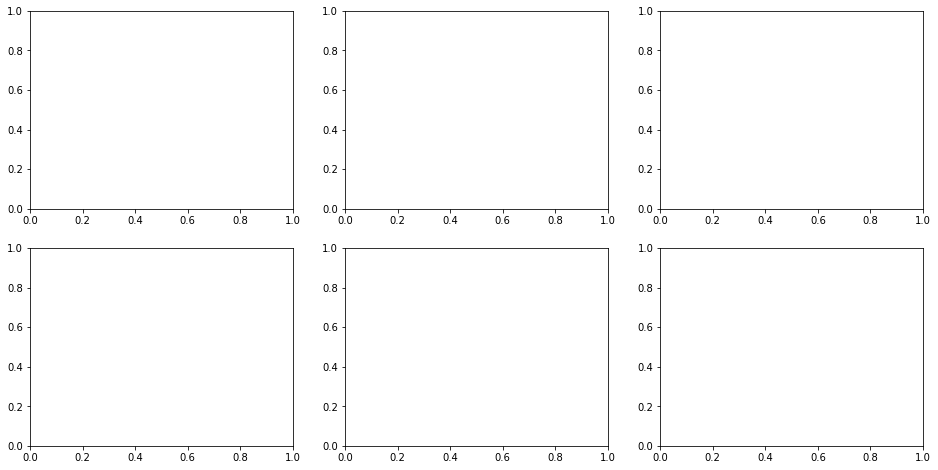

In [3]:
federated.train(10)

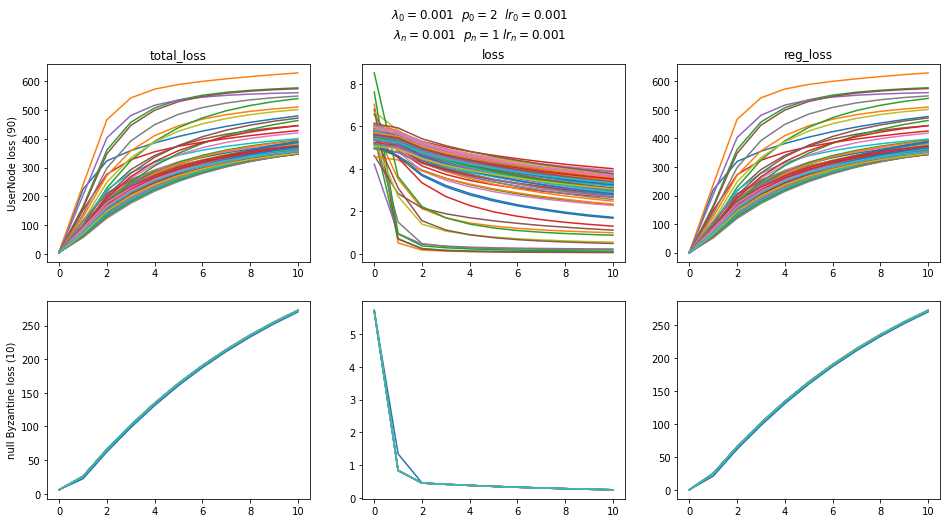

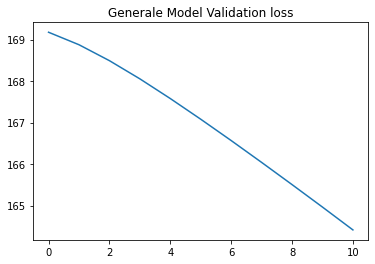

In [7]:
federated.plot_training_history(save_results=False, plt_name = '')

# Wiki Model

In [4]:
pipeline = Pipeline('CONFIG_MODEL_WIKI.json', load_model_data = True)

100%|██████████| 61/61 [00:01<00:00, 56.44it/s]


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [5]:
pipeline.evaluate()

100%|██████████| 1552/1552 [00:03<00:00, 484.10it/s]


9.20816223154363

In [6]:
pipeline.perplexity()

100%|██████████| 1552/1552 [00:06<00:00, 235.15it/s]


9978.591554523126

  0%|          | 0/158839 [00:00<?, ?it/s]

Train loss at epoch 0 : 9.207809743970746
Eval loss at epoch 0 : 9.207637770469688
updating best metric


  6%|▋         | 10020/158839 [01:37<24:11, 102.51it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1048576.0


  8%|▊         | 12022/158839 [01:56<23:26, 104.39it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1048576.0


  9%|▉         | 14024/158839 [02:16<23:14, 103.87it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1048576.0


 10%|█         | 16026/158839 [02:35<22:54, 103.88it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1048576.0


 11%|█▏        | 18028/158839 [02:54<22:57, 102.24it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1048576.0


 13%|█▎        | 20030/158839 [03:14<22:24, 103.26it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1048576.0


 14%|█▍        | 22032/158839 [03:33<21:44, 104.85it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1048576.0


 15%|█▍        | 23572/158839 [03:48<21:34, 104.50it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 17%|█▋        | 27576/158839 [04:27<21:15, 102.92it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1048576.0


 19%|█▊        | 29578/158839 [04:46<20:48, 103.56it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1048576.0


 20%|█▉        | 31080/158839 [05:01<20:32, 103.69it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 22%|██▏       | 35084/158839 [05:40<19:51, 103.90it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1048576.0


 23%|██▎       | 36624/158839 [05:55<19:35, 104.01it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 25%|██▌       | 40320/158839 [06:31<18:58, 104.10it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 27%|██▋       | 42927/158839 [06:56<18:55, 102.08it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 30%|██▉       | 46932/158839 [07:35<18:01, 103.50it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1048576.0


 30%|███       | 47735/158839 [07:43<17:49, 103.87it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 32%|███▏      | 51046/158839 [08:15<17:16, 104.02it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 35%|███▍      | 54808/158839 [08:51<16:37, 104.29it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 37%|███▋      | 58769/158839 [09:30<16:05, 103.65it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 38%|███▊      | 61002/158839 [09:51<15:45, 103.45it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 40%|███▉      | 63103/158839 [10:12<15:32, 102.62it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 41%|████▏     | 65534/158839 [10:35<14:55, 104.24it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 43%|████▎     | 68318/158839 [11:02<14:32, 103.75it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 45%|████▌     | 71596/158839 [11:34<14:13, 102.25it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 47%|████▋     | 74181/158839 [11:59<13:47, 102.29it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 49%|████▊     | 77250/158839 [12:29<13:12, 102.97it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 50%|████▉     | 79263/158839 [12:48<12:46, 103.81it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 51%|█████▏    | 81693/158839 [13:12<12:24, 103.69it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 52%|█████▏    | 81858/158839 [13:14<12:19, 104.08it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 55%|█████▌    | 87864/158839 [14:12<11:31, 102.64it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1048576.0


 55%|█████▌    | 87930/158839 [14:13<11:22, 103.95it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 57%|█████▋    | 90020/158839 [14:33<11:00, 104.17it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 58%|█████▊    | 92176/158839 [14:54<10:43, 103.60it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 59%|█████▉    | 94243/158839 [15:14<10:24, 103.45it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 61%|██████    | 96817/158839 [15:39<09:56, 103.90it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 62%|██████▏   | 98885/158839 [15:59<09:37, 103.85it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 64%|██████▎   | 100964/158839 [16:19<09:19, 103.40it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 65%|██████▍   | 103098/158839 [16:40<09:00, 103.20it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 66%|██████▌   | 105109/158839 [16:59<08:49, 101.46it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 67%|██████▋   | 107133/158839 [17:19<08:16, 104.11it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 69%|██████▉   | 109564/158839 [17:42<07:53, 104.17it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 70%|███████   | 111621/158839 [18:02<07:36, 103.54it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 72%|███████▏  | 113678/158839 [18:22<07:16, 103.46it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 73%|███████▎  | 115696/158839 [18:42<07:10, 100.21it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 74%|███████▍  | 117804/158839 [19:03<06:45, 101.18it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 75%|███████▌  | 119838/158839 [19:23<06:23, 101.79it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 77%|███████▋  | 121843/158839 [19:43<06:01, 102.37it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 78%|███████▊  | 123896/158839 [20:03<05:45, 101.05it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 80%|████████  | 127664/158839 [20:40<05:09, 100.75it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 82%|████████▏ | 129840/158839 [21:02<04:51, 99.53it/s] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 83%|████████▎ | 131970/158839 [21:23<04:24, 101.77it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 85%|████████▌ | 135205/158839 [21:54<03:49, 102.77it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 86%|████████▌ | 136426/158839 [22:06<03:43, 100.48it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 88%|████████▊ | 140513/158839 [22:46<02:53, 105.32it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 90%|████████▉ | 142688/158839 [23:07<02:34, 104.83it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 91%|█████████ | 144390/158839 [23:24<02:19, 103.35it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 94%|█████████▎| 148581/158839 [24:04<01:39, 102.71it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 95%|█████████▍| 150682/158839 [24:25<01:18, 103.55it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 95%|█████████▍| 150880/158839 [24:27<01:17, 102.98it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 98%|█████████▊| 154937/158839 [25:06<00:37, 104.66it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 99%|█████████▉| 156950/158839 [25:25<00:18, 104.27it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  0%|          | 0/158839 [00:00<?, ?it/s]

Train loss at epoch 1 : 4.90612839692121
Eval loss at epoch 1 : 4.620512191067452
updating best metric


  0%|          | 199/158839 [00:02<25:49, 102.36it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  1%|▏         | 2256/158839 [00:22<25:29, 102.39it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  3%|▎         | 4115/158839 [00:39<24:50, 103.82it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


  5%|▌         | 8201/158839 [01:19<24:28, 102.58it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  7%|▋         | 10335/158839 [01:40<23:42, 104.39it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  8%|▊         | 12568/158839 [02:01<23:46, 102.54it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  9%|▉         | 14647/158839 [02:21<23:52, 100.64it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 10%|█         | 16077/158839 [02:35<22:50, 104.18it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 13%|█▎        | 20044/158839 [03:14<22:52, 101.10it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 15%|█▌        | 24092/158839 [03:53<21:36, 103.90it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 16%|█▋        | 26116/158839 [04:13<21:09, 104.51it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 18%|█▊        | 28338/158839 [04:34<21:05, 103.12it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 18%|█▊        | 28888/158839 [04:39<20:49, 103.99it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 21%|██        | 32950/158839 [05:19<20:26, 102.64it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 22%|██▏       | 35040/158839 [05:39<20:08, 102.42it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 23%|██▎       | 37295/158839 [06:01<19:27, 104.09it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 24%|██▎       | 37504/158839 [06:03<19:23, 104.27it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 26%|██▌       | 41134/158839 [06:38<18:49, 104.24it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 28%|██▊       | 45182/158839 [07:17<18:10, 104.20it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 30%|██▉       | 47184/158839 [07:37<18:07, 102.63it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 30%|███       | 47833/158839 [07:43<17:47, 103.95it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 32%|███▏      | 51023/158839 [08:14<17:25, 103.16it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 34%|███▍      | 54521/158839 [08:48<16:41, 104.20it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 37%|███▋      | 58554/158839 [09:27<16:15, 102.83it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 37%|███▋      | 58950/158839 [09:30<15:58, 104.21it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 40%|███▉      | 62998/158839 [10:10<15:20, 104.11it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 41%|████      | 65044/158839 [10:29<15:02, 103.96it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 42%|████▏     | 66133/158839 [10:40<14:48, 104.30it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 44%|████▍     | 69553/158839 [11:13<15:19, 97.05it/s] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 46%|████▋     | 73584/158839 [11:52<13:41, 103.76it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 47%|████▋     | 75002/158839 [12:06<13:25, 104.04it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 50%|████▉     | 79061/158839 [12:45<12:42, 104.64it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 51%|█████     | 81151/158839 [13:05<12:25, 104.16it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 52%|█████▏    | 81994/158839 [13:14<12:58, 98.74it/s] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 54%|█████▍    | 86184/158839 [13:54<11:41, 103.58it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 56%|█████▌    | 88285/158839 [14:15<11:18, 104.02it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 57%|█████▋    | 90342/158839 [14:34<10:57, 104.13it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 57%|█████▋    | 91332/158839 [14:44<10:59, 102.36it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 59%|█████▉    | 94071/158839 [15:11<10:21, 104.25it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 62%|██████▏   | 98293/158839 [15:52<09:50, 102.57it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 62%|██████▏   | 98414/158839 [15:53<09:40, 104.11it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 64%|██████▎   | 100922/158839 [16:17<09:15, 104.18it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 65%|██████▍   | 103089/158839 [16:38<08:55, 104.14it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 67%|██████▋   | 106620/158839 [17:12<08:36, 101.07it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 69%|██████▉   | 110178/158839 [17:47<07:52, 102.94it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 71%|███████   | 112587/158839 [18:10<07:23, 104.18it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 73%|███████▎  | 115469/158839 [18:38<06:55, 104.30it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 75%|███████▌  | 119455/158839 [19:17<06:23, 102.81it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 77%|███████▋  | 121710/158839 [19:38<05:55, 104.43it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 78%|███████▊  | 123866/158839 [19:59<05:38, 103.27it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 79%|███████▉  | 125998/158839 [20:20<05:15, 104.07it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 80%|████████  | 127615/158839 [20:36<04:59, 104.38it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 84%|████████▍ | 133624/158839 [21:34<04:05, 102.72it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 85%|████████▍ | 134713/158839 [21:44<03:54, 103.06it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 87%|████████▋ | 137584/158839 [22:12<03:24, 103.78it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 87%|████████▋ | 137804/158839 [22:14<03:23, 103.57it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 89%|████████▉ | 142072/158839 [22:56<02:40, 104.59it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 92%|█████████▏| 145827/158839 [23:32<02:05, 103.83it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 92%|█████████▏| 146498/158839 [23:39<01:59, 103.42it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 96%|█████████▌| 151877/158839 [24:31<01:06, 104.24it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 98%|█████████▊| 155693/158839 [25:08<00:30, 103.96it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


100%|█████████▉| 158424/158839 [25:34<00:04, 102.89it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


  0%|          | 0/158839 [00:00<?, ?it/s]

Train loss at epoch 2 : 4.737581289809938
Eval loss at epoch 2 : 4.577300394162066
updating best metric


  1%|▏         | 2243/158839 [00:21<25:27, 102.52it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


  4%|▍         | 6192/158839 [00:59<24:27, 104.00it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


  6%|▋         | 10229/158839 [01:39<23:57, 103.41it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  7%|▋         | 10647/158839 [01:43<23:38, 104.48it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


  7%|▋         | 11637/158839 [01:52<23:29, 104.45it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 11%|█         | 17555/158839 [02:49<22:41, 103.74it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 13%|█▎        | 20602/158839 [03:19<22:20, 103.11it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 15%|█▍        | 23572/158839 [03:48<21:35, 104.43it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 17%|█▋        | 27576/158839 [04:26<21:20, 102.52it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 17%|█▋        | 27785/158839 [04:28<20:56, 104.29it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 19%|█▉        | 30216/158839 [04:52<20:41, 103.63it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 19%|█▉        | 30403/158839 [04:54<20:26, 104.69it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 22%|██▏       | 34253/158839 [05:31<19:49, 104.71it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 24%|██▍       | 37802/158839 [06:05<19:18, 104.46it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 26%|██▌       | 41212/158839 [06:38<18:50, 104.03it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 28%|██▊       | 44677/158839 [07:12<18:32, 102.58it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 30%|███       | 47974/158839 [07:43<17:40, 104.57it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 33%|███▎      | 52352/158839 [08:26<17:03, 104.03it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 35%|███▍      | 54838/158839 [08:50<16:39, 104.03it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 37%|███▋      | 58853/158839 [09:29<15:59, 104.20it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 37%|███▋      | 59205/158839 [09:32<16:25, 101.06it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 39%|███▊      | 61480/158839 [09:54<15:53, 102.08it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 39%|███▉      | 62382/158839 [10:03<15:21, 104.64it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 42%|████▏     | 66936/158839 [10:47<14:55, 102.62it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 44%|████▍     | 69741/158839 [11:14<14:23, 103.18it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 46%|████▌     | 72631/158839 [11:42<13:58, 102.85it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 48%|████▊     | 75908/158839 [12:14<13:10, 104.85it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 50%|████▉     | 79164/158839 [12:45<12:42, 104.48it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 52%|█████▏    | 83168/158839 [13:24<12:08, 103.93it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 53%|█████▎    | 83905/158839 [13:31<11:56, 104.61it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 55%|█████▍    | 86619/158839 [13:57<11:34, 104.03it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 55%|█████▌    | 87950/158839 [14:10<11:17, 104.64it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 56%|█████▌    | 88863/158839 [14:19<11:18, 103.17it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 60%|█████▉    | 94957/158839 [15:18<10:12, 104.31it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 61%|██████▏   | 97300/158839 [15:41<09:48, 104.55it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 61%|██████▏   | 97322/158839 [15:41<09:49, 104.28it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 64%|██████▍   | 101392/158839 [16:20<09:08, 104.71it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 65%|██████▌   | 103856/158839 [16:44<08:54, 102.87it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 67%|██████▋   | 105946/158839 [17:04<08:35, 102.53it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 68%|██████▊   | 107354/158839 [17:18<08:14, 104.13it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 70%|███████   | 111557/158839 [17:58<07:42, 102.17it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 72%|███████▏  | 115077/158839 [18:32<06:58, 104.65it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 74%|███████▍  | 117739/158839 [18:58<06:33, 104.38it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 77%|███████▋  | 121754/158839 [19:37<05:57, 103.79it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 77%|███████▋  | 122953/158839 [19:49<05:42, 104.72it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 79%|███████▉  | 126264/158839 [20:21<05:11, 104.59it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 81%|████████  | 128640/158839 [20:43<04:50, 103.98it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 82%|████████▏ | 130785/158839 [21:04<04:32, 102.95it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 84%|████████▍ | 133979/158839 [21:35<04:01, 102.89it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 87%|████████▋ | 137972/158839 [22:14<03:22, 103.02it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 87%|████████▋ | 138797/158839 [22:22<03:15, 102.77it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 90%|████████▉ | 142229/158839 [22:55<02:39, 104.34it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 91%|█████████ | 144671/158839 [23:19<02:16, 103.89it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 93%|█████████▎| 147089/158839 [23:42<01:52, 104.07it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 94%|█████████▍| 149410/158839 [24:05<01:30, 104.13it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 95%|█████████▍| 150246/158839 [24:13<01:21, 104.98it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 97%|█████████▋| 154580/158839 [24:55<00:40, 103.92it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 99%|█████████▉| 157297/158839 [25:21<00:14, 104.68it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 99%|█████████▉| 157539/158839 [25:23<00:12, 104.14it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


  0%|          | 0/158839 [00:00<?, ?it/s]

Train loss at epoch 3 : 4.711549753684624
Eval loss at epoch 3 : 4.556709840851049
updating best metric


  2%|▏         | 3796/158839 [00:37<25:07, 102.88it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


  3%|▎         | 4060/158839 [00:39<24:56, 103.42it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


  4%|▍         | 6106/158839 [00:59<24:54, 102.20it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


  6%|▌         | 9395/158839 [01:31<23:55, 104.12it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


  9%|▊         | 13705/158839 [02:13<23:15, 103.98it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 10%|█         | 15981/158839 [02:35<22:50, 104.24it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 11%|█▏        | 17994/158839 [02:54<22:34, 103.96it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 11%|█▏        | 18170/158839 [02:56<22:56, 102.16it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 14%|█▍        | 22471/158839 [03:38<21:48, 104.23it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 16%|█▌        | 25054/158839 [04:03<21:21, 104.38it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 17%|█▋        | 27298/158839 [04:25<21:02, 104.17it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 19%|█▉        | 30554/158839 [04:57<20:43, 103.13it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 21%|██        | 32963/158839 [05:20<20:15, 103.56it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 22%|██▏       | 34998/158839 [05:40<19:48, 104.22it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 24%|██▎       | 37517/158839 [06:04<19:34, 103.31it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 26%|██▌       | 40718/158839 [06:35<18:54, 104.09it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 28%|██▊       | 43886/158839 [07:06<18:40, 102.55it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 29%|██▉       | 46053/158839 [07:27<18:04, 103.97it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 31%|███       | 48583/158839 [07:52<17:45, 103.49it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 33%|███▎      | 51804/158839 [08:23<17:09, 103.94it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 34%|███▍      | 53872/158839 [08:43<16:49, 103.95it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 36%|███▌      | 56886/158839 [09:12<16:17, 104.29it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 37%|███▋      | 59306/158839 [09:36<15:55, 104.12it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 39%|███▉      | 62003/158839 [10:02<15:35, 103.51it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 41%|████      | 64368/158839 [10:25<15:08, 103.99it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 41%|████      | 65490/158839 [10:36<14:58, 103.94it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 44%|████▍     | 69615/158839 [11:16<14:20, 103.73it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 45%|████▌     | 71936/158839 [11:38<13:55, 103.96it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 46%|████▌     | 72607/158839 [11:45<13:47, 104.23it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 49%|████▉     | 78613/158839 [12:43<12:51, 103.98it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 50%|████▉     | 78954/158839 [12:46<12:58, 102.64it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 51%|█████     | 80978/158839 [13:06<12:41, 102.24it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 52%|█████▏    | 83200/158839 [13:28<12:07, 104.03it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 54%|█████▍    | 86360/158839 [13:58<11:40, 103.40it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 56%|█████▌    | 88384/158839 [14:18<11:15, 104.37it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 57%|█████▋    | 91321/158839 [14:46<10:57, 102.71it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 59%|█████▉    | 93488/158839 [15:07<10:27, 104.19it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 60%|██████    | 95710/158839 [15:29<10:13, 102.94it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 60%|██████    | 96084/158839 [15:33<10:03, 104.06it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 64%|██████▎   | 100932/158839 [16:20<09:16, 104.06it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 64%|██████▍   | 102142/158839 [16:32<09:11, 102.84it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 67%|██████▋   | 106475/158839 [17:14<08:29, 102.73it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 68%|██████▊   | 108631/158839 [17:34<08:03, 103.76it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 68%|██████▊   | 108675/158839 [17:35<08:02, 103.95it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 71%|███████▏  | 113537/158839 [18:22<07:25, 101.63it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 73%|███████▎  | 115891/158839 [18:45<06:52, 104.00it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 74%|███████▍  | 117937/158839 [19:05<06:32, 104.10it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 75%|███████▍  | 118465/158839 [19:10<06:27, 104.08it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 77%|███████▋  | 122557/158839 [19:50<05:50, 103.61it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 78%|███████▊  | 123118/158839 [19:55<06:32, 91.03it/s] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 79%|███████▉  | 125522/158839 [20:19<05:24, 102.56it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 81%|████████  | 128566/158839 [20:48<04:51, 103.89it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 84%|████████▎ | 132933/158839 [21:31<04:09, 103.86it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 85%|████████▌ | 135056/158839 [21:51<03:51, 102.54it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 86%|████████▋ | 137230/158839 [22:12<03:27, 103.96it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 88%|████████▊ | 139307/158839 [22:33<03:07, 104.01it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 88%|████████▊ | 139395/158839 [22:33<03:08, 102.99it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 90%|████████▉ | 142739/158839 [23:06<02:36, 102.89it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 93%|█████████▎| 147018/158839 [23:47<01:53, 103.88it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 94%|█████████▍| 149110/158839 [24:08<01:33, 104.32it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 95%|█████████▌| 151475/158839 [24:31<01:10, 104.15it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 97%|█████████▋| 153532/158839 [24:51<00:50, 104.07it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 98%|█████████▊| 155820/158839 [25:13<00:28, 104.45it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 98%|█████████▊| 156249/158839 [25:17<00:24, 103.96it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


  0%|          | 0/158839 [00:00<?, ?it/s]

Train loss at epoch 4 : 4.697533622114734
Eval loss at epoch 4 : 4.550751222921989
updating best metric


  1%|          | 815/158839 [00:08<25:29, 103.33it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


  2%|▏         | 3281/158839 [00:32<24:48, 104.54it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


  4%|▍         | 6833/158839 [01:06<24:15, 104.42it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


  7%|▋         | 11202/158839 [01:48<23:34, 104.36it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


  8%|▊         | 13456/158839 [02:10<24:22, 99.42it/s] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 10%|▉         | 15460/158839 [02:30<23:25, 101.98it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 11%|█         | 17635/158839 [02:51<22:35, 104.18it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 13%|█▎        | 19953/158839 [03:13<22:07, 104.59it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 14%|█▍        | 22252/158839 [03:36<21:50, 104.19it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 14%|█▍        | 22329/158839 [03:36<21:44, 104.67it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 14%|█▍        | 22648/158839 [03:39<21:46, 104.25it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 18%|█▊        | 28929/158839 [04:40<20:43, 104.46it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 20%|█▉        | 31040/158839 [05:01<20:26, 104.17it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 21%|██        | 32965/158839 [05:20<20:23, 102.85it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 23%|██▎       | 37068/158839 [05:59<19:28, 104.20it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 25%|██▍       | 39698/158839 [06:25<19:26, 102.15it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 26%|██▋       | 42016/158839 [06:47<19:24, 100.35it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 28%|██▊       | 43971/158839 [07:06<18:19, 104.50it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 29%|██▉       | 46721/158839 [07:33<17:55, 104.25it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 31%|███       | 48745/158839 [07:52<17:55, 102.33it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 33%|███▎      | 53004/158839 [08:34<16:54, 104.31it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 35%|███▍      | 55344/158839 [08:56<16:50, 102.42it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 36%|███▌      | 57571/158839 [09:18<16:11, 104.26it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 37%|███▋      | 58176/158839 [09:24<16:03, 104.52it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 39%|███▉      | 62620/158839 [10:07<15:22, 104.29it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 40%|████      | 63802/158839 [10:18<15:13, 103.99it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 42%|████▏     | 66794/158839 [10:47<14:51, 103.22it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 45%|████▍     | 70820/158839 [11:26<14:00, 104.69it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 46%|████▌     | 73361/158839 [11:51<13:41, 104.02it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 46%|████▋     | 73537/158839 [11:53<13:45, 103.36it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 48%|████▊     | 76271/158839 [12:19<13:12, 104.22it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 50%|████▉     | 78966/158839 [12:45<12:53, 103.28it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 50%|█████     | 79516/158839 [12:50<12:38, 104.57it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 54%|█████▍    | 85610/158839 [13:49<11:45, 103.82it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 54%|█████▍    | 86006/158839 [13:53<11:37, 104.37it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 57%|█████▋    | 90255/158839 [14:34<11:02, 103.58it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 58%|█████▊    | 92444/158839 [14:56<10:38, 103.96it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 59%|█████▉    | 94171/158839 [15:12<10:29, 102.75it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 61%|██████    | 96734/158839 [15:37<10:03, 102.84it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 63%|██████▎   | 99825/158839 [16:07<09:32, 103.01it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 66%|██████▌   | 104669/158839 [16:54<08:39, 104.34it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 67%|██████▋   | 106781/158839 [17:15<08:27, 102.64it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 68%|██████▊   | 107705/158839 [17:24<08:08, 104.58it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 68%|██████▊   | 108530/158839 [17:32<08:01, 104.56it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 72%|███████▏  | 114966/158839 [18:34<06:59, 104.54it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 74%|███████▍  | 117628/158839 [19:00<06:41, 102.68it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 75%|███████▌  | 119168/158839 [19:15<06:25, 102.93it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 77%|███████▋  | 122847/158839 [19:51<05:58, 100.53it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 79%|███████▊  | 125017/158839 [20:13<05:44, 98.04it/s] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 81%|████████▏ | 129085/158839 [20:53<04:53, 101.28it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 82%|████████▏ | 129833/158839 [21:00<04:46, 101.18it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 84%|████████▍ | 133776/158839 [21:39<04:06, 101.57it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 85%|████████▍ | 134995/158839 [21:51<03:54, 101.58it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 89%|████████▉ | 141297/158839 [22:53<02:48, 104.20it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 89%|████████▉ | 141792/158839 [22:58<02:44, 103.75it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 92%|█████████▏| 145389/158839 [23:33<02:09, 103.60it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 93%|█████████▎| 147644/158839 [23:54<01:47, 104.13it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 96%|█████████▌| 151860/158839 [24:35<01:06, 104.32it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 97%|█████████▋| 153873/158839 [24:55<00:48, 102.34it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 97%|█████████▋| 154390/158839 [25:00<00:43, 102.59it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 99%|█████████▉| 157041/158839 [25:25<00:17, 103.80it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


  0%|          | 0/158839 [00:00<?, ?it/s]

Train loss at epoch 5 : 4.68765539322018
Eval loss at epoch 5 : 4.539738260914056
updating best metric


  0%|          | 506/158839 [00:05<25:17, 104.31it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


  3%|▎         | 4531/158839 [00:44<24:49, 103.61it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


  4%|▍         | 6860/158839 [01:07<24:53, 101.73it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


  6%|▌         | 9068/158839 [01:29<24:28, 102.00it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


  6%|▋         | 10132/158839 [01:39<24:12, 102.35it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


  9%|▉         | 14188/158839 [02:19<23:41, 101.76it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 10%|█         | 16309/158839 [02:40<23:53, 99.41it/s] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 11%|█▏        | 18165/158839 [02:59<23:00, 101.91it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 14%|█▍        | 22257/158839 [03:39<22:20, 101.87it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 15%|█▌        | 24343/158839 [04:00<22:05, 101.49it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 15%|█▌        | 24550/158839 [04:02<21:55, 102.08it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 18%|█▊        | 28680/158839 [04:43<21:10, 102.47it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 18%|█▊        | 28845/158839 [04:45<20:49, 104.02it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 21%|██        | 32847/158839 [05:23<20:07, 104.34it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 22%|██▏       | 34398/158839 [05:38<19:58, 103.86it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 23%|██▎       | 36488/158839 [05:59<19:38, 103.84it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 25%|██▌       | 39729/158839 [06:30<19:24, 102.30it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 28%|██▊       | 43783/158839 [07:10<18:21, 104.47it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 28%|██▊       | 43926/158839 [07:11<18:29, 103.57it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 29%|██▉       | 46665/158839 [07:37<17:57, 104.12it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 31%|███       | 49580/158839 [08:06<17:37, 103.33it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 34%|███▍      | 53663/158839 [08:45<17:11, 102.00it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 35%|███▌      | 55684/158839 [09:05<16:43, 102.85it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 36%|███▌      | 56839/158839 [09:16<16:18, 104.21it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 37%|███▋      | 58951/158839 [09:37<15:59, 104.10it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 39%|███▊      | 61338/158839 [10:00<15:37, 104.03it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 41%|████      | 65356/158839 [10:39<14:57, 104.12it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 43%|████▎     | 67680/158839 [11:02<14:37, 103.94it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 43%|████▎     | 68120/158839 [11:06<14:33, 103.84it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 46%|████▌     | 72322/158839 [11:46<13:52, 103.91it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 46%|████▌     | 72795/158839 [11:51<13:43, 104.51it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 48%|████▊     | 76819/158839 [12:30<13:18, 102.76it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 50%|████▉     | 78832/158839 [12:50<12:47, 104.19it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 50%|█████     | 79954/158839 [13:01<12:52, 102.16it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 52%|█████▏    | 83331/158839 [13:33<12:10, 103.43it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 55%|█████▌    | 87368/158839 [14:12<11:26, 104.17it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 55%|█████▌    | 88072/158839 [14:19<11:23, 103.54it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 58%|█████▊    | 91572/158839 [14:53<10:51, 103.30it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 60%|██████    | 95608/158839 [15:32<10:09, 103.80it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 61%|██████▏   | 97632/158839 [15:52<09:43, 104.89it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 62%|██████▏   | 99216/158839 [16:07<09:34, 103.82it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 64%|██████▍   | 101329/158839 [16:28<10:50, 88.44it/s] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 65%|██████▌   | 103388/158839 [16:48<09:02, 102.23it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 66%|██████▌   | 105207/158839 [17:06<08:41, 102.87it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 70%|███████   | 111235/158839 [18:04<07:38, 103.77it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 71%|███████▏  | 113281/158839 [18:24<07:18, 103.96it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 72%|███████▏  | 114291/158839 [18:34<07:07, 104.26it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 73%|███████▎  | 116062/158839 [18:51<06:51, 103.89it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 76%|███████▌  | 120853/158839 [19:38<06:09, 102.85it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 78%|███████▊  | 123845/158839 [20:06<05:36, 103.91it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 79%|███████▉  | 125264/158839 [20:20<05:27, 102.63it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 81%|████████  | 128442/158839 [20:51<04:52, 103.96it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 84%|████████▍ | 133677/158839 [21:42<04:01, 104.37it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 85%|████████▍ | 134942/158839 [21:54<03:49, 104.22it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 89%|████████▉ | 141110/158839 [22:54<02:50, 104.18it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 89%|████████▉ | 141803/158839 [23:01<02:44, 103.32it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 91%|█████████ | 143948/158839 [23:21<02:23, 104.05it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 93%|█████████▎| 148029/158839 [24:01<01:44, 103.91it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 93%|█████████▎| 148073/158839 [24:01<01:43, 103.81it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 96%|█████████▌| 152112/158839 [24:41<01:05, 102.83it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 97%|█████████▋| 154180/158839 [25:01<00:45, 102.92it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 98%|█████████▊| 155160/158839 [25:10<00:35, 102.36it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


  0%|          | 0/158839 [00:00<?, ?it/s]

Train loss at epoch 6 : 4.679811653007364
Eval loss at epoch 6 : 4.530181580764858
updating best metric


  0%|          | 386/158839 [00:03<25:24, 103.95it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


  1%|          | 1528/158839 [00:15<25:56, 101.06it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


  3%|▎         | 5535/158839 [00:54<24:33, 104.02it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


  4%|▍         | 6250/158839 [01:01<24:30, 103.74it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


  5%|▌         | 8560/158839 [01:23<24:13, 103.37it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


  7%|▋         | 10727/158839 [01:44<23:36, 104.53it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


  8%|▊         | 13356/158839 [02:09<23:15, 104.27it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


  9%|▊         | 13510/158839 [02:11<23:15, 104.15it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 12%|█▏        | 19742/158839 [03:11<22:15, 104.18it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 14%|█▎        | 21741/158839 [03:31<22:03, 103.57it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 14%|█▍        | 22896/158839 [03:42<21:44, 104.23it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 16%|█▌        | 25107/158839 [04:04<21:24, 104.08it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 16%|█▌        | 25690/158839 [04:09<21:17, 104.22it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 19%|█▉        | 30027/158839 [04:51<20:36, 104.18it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 20%|█▉        | 31160/158839 [05:02<20:25, 104.17it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 21%|██        | 33217/158839 [05:22<20:03, 104.37it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 24%|██▎       | 37639/158839 [06:05<19:37, 102.93it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 26%|██▌       | 41325/158839 [06:41<19:50, 98.70it/s] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 28%|██▊       | 44657/158839 [07:13<18:21, 103.70it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 29%|██▉       | 46732/158839 [07:33<17:56, 104.17it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 31%|███       | 48899/158839 [07:54<17:32, 104.47it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 33%|███▎      | 52936/158839 [08:34<16:56, 104.18it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 34%|███▍      | 53930/158839 [08:43<16:50, 103.86it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 36%|███▌      | 56636/158839 [09:10<16:21, 104.08it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 37%|███▋      | 58550/158839 [09:28<16:09, 103.40it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 40%|████      | 63577/158839 [10:17<15:10, 104.63it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 40%|████      | 63830/158839 [10:19<15:16, 103.62it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 44%|████▍     | 69511/158839 [11:15<14:25, 103.16it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 46%|████▋     | 73542/158839 [11:54<13:38, 104.22it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 48%|████▊     | 75588/158839 [12:14<13:18, 104.27it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 49%|████▉     | 77640/158839 [12:34<13:00, 104.06it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 50%|█████     | 79675/158839 [12:54<12:43, 103.75it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 51%|█████     | 80599/158839 [13:03<12:44, 102.30it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 52%|█████▏    | 82480/158839 [13:21<12:14, 104.01it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 53%|█████▎    | 84020/158839 [13:36<12:01, 103.69it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


 57%|█████▋    | 90070/158839 [14:34<11:00, 104.08it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 57%|█████▋    | 90422/158839 [14:38<11:16, 101.10it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 60%|█████▉    | 94623/158839 [15:19<10:18, 103.87it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 61%|██████    | 96704/158839 [15:39<09:54, 104.43it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 61%|██████    | 96891/158839 [15:41<09:54, 104.24it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 64%|██████▍   | 102006/158839 [16:30<09:13, 102.74it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 67%|██████▋   | 105628/158839 [17:06<08:35, 103.25it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 69%|██████▉   | 109632/158839 [17:45<07:54, 103.80it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 70%|███████   | 111238/158839 [18:00<07:46, 102.04it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 71%|███████▏  | 113240/158839 [18:20<07:19, 103.76it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 73%|███████▎  | 116208/158839 [18:49<06:49, 103.98it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 75%|███████▍  | 118507/158839 [19:11<06:30, 103.36it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 77%|███████▋  | 122509/158839 [19:50<05:58, 101.34it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 77%|███████▋  | 122805/158839 [19:53<05:58, 100.61it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 78%|███████▊  | 123839/158839 [20:03<05:36, 104.11it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 81%|████████  | 127919/158839 [20:44<04:57, 103.87it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 81%|████████▏ | 129272/158839 [20:57<04:44, 104.08it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 82%|████████▏ | 129591/158839 [21:00<04:45, 102.38it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


 87%|████████▋ | 137747/158839 [22:20<03:27, 101.55it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 88%|████████▊ | 139123/158839 [22:34<03:20, 98.26it/s] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 89%|████████▊ | 140953/158839 [22:52<02:51, 104.17it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 93%|█████████▎| 146991/158839 [23:51<01:54, 103.62it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 94%|█████████▍| 149048/158839 [24:11<01:34, 103.33it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 95%|█████████▍| 150764/158839 [24:27<01:18, 103.15it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 97%|█████████▋| 154142/158839 [25:01<00:45, 102.93it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 98%|█████████▊| 156287/158839 [25:22<00:24, 103.90it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


  0%|          | 1/158839 [00:00<7:02:37,  6.26it/s]

Train loss at epoch 7 : 4.67320912650077
Eval loss at epoch 7 : 4.530913700688535


  0%|          | 252/158839 [00:02<26:01, 101.57it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


  1%|          | 1869/158839 [00:18<25:25, 102.93it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


  3%|▎         | 4794/158839 [00:46<24:33, 104.53it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


  6%|▌         | 9367/158839 [01:31<23:58, 103.89it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


  8%|▊         | 12326/158839 [02:00<23:51, 102.33it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


  9%|▉         | 14438/158839 [02:20<23:15, 103.45it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 10%|█         | 16572/158839 [02:41<22:47, 104.05it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 12%|█▏        | 19186/158839 [03:06<22:21, 104.08it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 14%|█▍        | 22354/158839 [03:37<22:16, 102.09it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 16%|█▌        | 24796/158839 [04:01<21:39, 103.17it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 16%|█▋        | 26160/158839 [04:14<21:13, 104.16it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 19%|█▉        | 30677/158839 [04:58<20:53, 102.26it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 20%|█▉        | 31150/158839 [05:03<20:27, 104.05it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 22%|██▏       | 35583/158839 [05:46<19:42, 104.21it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 23%|██▎       | 35869/158839 [05:49<19:41, 104.05it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 26%|██▌       | 40979/158839 [06:38<19:10, 102.41it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 27%|██▋       | 43150/158839 [07:00<18:47, 102.62it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 29%|██▉       | 46780/158839 [07:35<17:55, 104.21it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 32%|███▏      | 50249/158839 [08:10<17:32, 103.17it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 34%|███▎      | 53460/158839 [08:42<17:24, 100.87it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 36%|███▌      | 57109/158839 [09:18<16:53, 100.41it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 39%|███▊      | 61160/158839 [09:58<16:07, 101.01it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 39%|███▊      | 61534/158839 [10:01<16:01, 101.19it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 40%|████      | 63670/158839 [10:22<15:38, 101.46it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 43%|████▎     | 67682/158839 [11:03<14:46, 102.79it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 44%|████▍     | 69698/158839 [11:22<14:58, 99.18it/s] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 44%|████▍     | 70185/158839 [11:27<15:08, 97.54it/s] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 45%|████▌     | 71927/158839 [11:45<14:21, 100.87it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 48%|████▊     | 75954/158839 [12:24<13:34, 101.78it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 49%|████▉     | 78154/158839 [12:46<13:22, 100.54it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 50%|████▉     | 78792/158839 [12:53<13:41, 97.50it/s] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 52%|█████▏    | 82339/158839 [13:28<12:19, 103.48it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 55%|█████▍    | 86739/158839 [14:11<11:44, 102.30it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 56%|█████▌    | 89127/158839 [14:34<11:17, 102.89it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 57%|█████▋    | 91278/158839 [14:56<10:49, 104.07it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 59%|█████▉    | 93379/158839 [15:16<10:25, 104.73it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 60%|█████▉    | 94686/158839 [15:29<10:44, 99.50it/s] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


 64%|██████▍   | 101347/158839 [16:34<09:26, 101.50it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 65%|██████▌   | 103913/158839 [17:00<08:59, 101.73it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 67%|██████▋   | 106881/158839 [17:30<08:29, 101.94it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 69%|██████▉   | 109315/158839 [17:54<08:10, 100.91it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 71%|███████   | 112651/158839 [18:27<07:37, 101.04it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 73%|███████▎  | 116671/158839 [19:07<06:47, 103.39it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 74%|███████▎  | 116990/158839 [19:10<06:47, 102.58it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 76%|███████▌  | 120993/158839 [19:49<06:03, 104.07it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 76%|███████▋  | 121360/158839 [19:53<06:08, 101.58it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 78%|███████▊  | 124621/158839 [20:25<05:44, 99.20it/s] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 80%|███████▉  | 126801/158839 [20:46<05:08, 103.95it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 81%|████████▏ | 129252/158839 [21:11<04:44, 103.88it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 83%|████████▎ | 131169/158839 [21:30<04:32, 101.40it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 84%|████████▍ | 133179/158839 [21:49<04:09, 102.90it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 86%|████████▋ | 137257/158839 [22:30<03:34, 100.44it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 86%|████████▋ | 137290/158839 [22:30<03:33, 100.92it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 89%|████████▊ | 140874/158839 [23:06<03:04, 97.61it/s] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 92%|█████████▏| 146455/158839 [24:01<02:11, 94.12it/s] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 93%|█████████▎| 147325/158839 [24:10<01:53, 101.17it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 95%|█████████▌| 151371/158839 [24:49<01:12, 103.11it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 96%|█████████▌| 152238/158839 [24:58<01:06, 99.66it/s] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 98%|█████████▊| 155598/158839 [25:31<00:31, 103.31it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 99%|█████████▉| 157647/158839 [25:52<00:11, 104.38it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


  0%|          | 0/158839 [00:00<?, ?it/s]

Train loss at epoch 8 : 4.666900625920186
Eval loss at epoch 8 : 4.521025094056881
updating best metric


  2%|▏         | 3664/158839 [00:36<24:58, 103.55it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


  3%|▎         | 5223/158839 [00:51<24:30, 104.47it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


  6%|▌         | 9641/158839 [01:35<25:04, 99.17it/s] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


  8%|▊         | 12350/158839 [02:02<23:55, 102.08it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


  9%|▉         | 14634/158839 [02:24<23:34, 101.93it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 11%|█         | 16891/158839 [02:47<23:40, 99.94it/s] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 12%|█▏        | 19211/158839 [03:10<23:15, 100.04it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 14%|█▎        | 21530/158839 [03:32<22:14, 102.89it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 14%|█▍        | 22184/158839 [03:39<22:32, 101.01it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 15%|█▌        | 24494/158839 [04:02<22:22, 100.10it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 18%|█▊        | 28520/158839 [04:41<21:29, 101.06it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 19%|█▊        | 29575/158839 [04:52<22:04, 97.59it/s] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 22%|██▏       | 34841/158839 [05:44<19:51, 104.09it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 24%|██▍       | 37848/158839 [06:13<19:27, 103.65it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 25%|██▌       | 40139/158839 [06:36<19:37, 100.79it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 27%|██▋       | 43380/158839 [07:09<18:31, 103.87it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 30%|██▉       | 47427/158839 [07:48<18:01, 103.00it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 30%|██▉       | 47625/158839 [07:50<18:01, 102.86it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 30%|███       | 48019/158839 [07:54<18:06, 101.95it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 32%|███▏      | 50411/158839 [08:18<19:10, 94.27it/s] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 34%|███▍      | 54035/158839 [08:53<16:39, 104.84it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 35%|███▌      | 56103/158839 [09:13<16:21, 104.63it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 35%|███▌      | 56367/158839 [09:15<16:21, 104.40it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


 39%|███▉      | 62252/158839 [10:12<15:40, 102.70it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 40%|███▉      | 63484/158839 [10:24<15:13, 104.41it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


 44%|████▍     | 70082/158839 [11:29<14:41, 100.68it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 46%|████▌     | 73201/158839 [12:00<14:24, 99.03it/s] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 47%|████▋     | 75282/158839 [12:21<13:40, 101.80it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 47%|████▋     | 75365/158839 [12:21<14:43, 94.44it/s] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 50%|█████     | 79669/158839 [13:04<13:03, 101.10it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 52%|█████▏    | 81998/158839 [13:27<12:29, 102.51it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 53%|█████▎    | 84678/158839 [13:53<12:15, 100.79it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 54%|█████▍    | 85409/158839 [14:01<12:03, 101.51it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 56%|█████▌    | 88579/158839 [14:32<11:33, 101.35it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 59%|█████▉    | 94441/158839 [15:30<10:41, 100.31it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 61%|██████▏   | 97316/158839 [15:59<09:56, 103.18it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 63%|██████▎   | 99980/158839 [16:25<09:50, 99.60it/s] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 64%|██████▍   | 102147/158839 [16:46<09:01, 104.70it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 65%|██████▍   | 102861/158839 [16:53<08:57, 104.12it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 67%|██████▋   | 106502/158839 [17:28<08:18, 104.93it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 70%|██████▉   | 111171/158839 [18:14<07:37, 104.14it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 72%|███████▏  | 114060/158839 [18:42<07:16, 102.57it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 72%|███████▏  | 114159/158839 [18:43<07:06, 104.83it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 74%|███████▎  | 116829/158839 [19:09<06:42, 104.48it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 76%|███████▌  | 120083/158839 [19:41<06:12, 104.17it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 79%|███████▊  | 124690/158839 [20:27<05:40, 100.35it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 80%|███████▉  | 126445/158839 [20:44<05:17, 101.98it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 83%|████████▎ | 131229/158839 [21:32<04:35, 100.36it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 84%|████████▍ | 133812/158839 [21:58<04:05, 101.74it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 86%|████████▌ | 136224/158839 [22:22<03:41, 102.09it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 88%|████████▊ | 140234/158839 [23:02<03:04, 100.99it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 89%|████████▊ | 140663/158839 [23:06<02:58, 101.61it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 90%|████████▉ | 142165/158839 [23:21<02:43, 101.70it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 91%|█████████ | 144924/158839 [23:48<02:16, 101.92it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 94%|█████████▍| 149051/158839 [24:29<01:36, 101.66it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


 94%|█████████▍| 150002/158839 [24:38<01:27, 101.05it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


 97%|█████████▋| 153711/158839 [25:15<00:50, 101.56it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|█████████▉| 158411/158839 [26:02<00:04, 101.00it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 349/349 [00:01<00:00, 300.79it/s]


Train loss at epoch 9 : 4.660830739142781
Eval loss at epoch 9 : 4.513793217076954
updating best metric


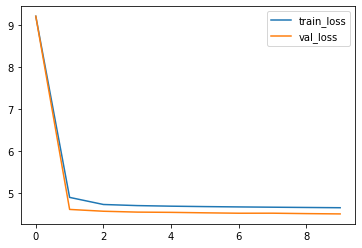

In [7]:
pipeline.train_model()

In [8]:
pipeline.evaluate()

100%|██████████| 1552/1552 [00:03<00:00, 469.16it/s]


4.513057091955057

In [9]:
pipeline.perplexity()

100%|██████████| 1552/1552 [00:06<00:00, 225.54it/s]


90.87367320576544

In [10]:
pipeline.generate(start_text = 'it')

'it is potentially distinctive to the fine state of research and the timber coat of arms covering long food and great quantities of large . Instead of moving from forest or swimming areas of form of the conservation area of much other marine environments such as their breeding sense of ecological guidance and habitats where they are free within the region per year track . Some kinds of plants resemble its effects because due to the Norwegian high water industry needs very important . The families not particularly able to survive land or or resources as the season is survival in'

In [1]:
import os
import pickle
import re

## FedSGD

In [1]:
from src.federated_pipeline import Federated_SGD

In [2]:
federated = Federated_SGD(
    "CONFIG_MODEL_WIKI.json",
    "CONFIG_FEDERATED_WIKI.json"
)

100%|██████████| 61/61 [00:01<00:00, 55.83it/s]


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
No path given, please enter a path to load the model.


100%|██████████| 1000/1000 [00:00<00:00, 9208.15it/s]


100%|██████████| 5/5 [00:00<00:00, 113.05it/s]

100%|██████████| 1/1 [00:00<00:00, 140.73it/s]

100%|██████████| 6/6 [00:00<00:00, 169.91it/s]

100%|██████████| 8/8 [00:00<00:00, 175.65it/s]

100%|██████████| 6/6 [00:00<00:00, 184.57it/s]

100%|██████████| 2/2 [00:00<00:00, 164.94it/s]

100%|██████████| 3/3 [00:00<00:00, 185.73it/s]

100%|██████████| 2/2 [00:00<00:00, 162.10it/s]

100%|██████████| 4/4 [00:00<00:00, 181.33it/s]

100%|██████████| 2/2 [00:00<00:00, 188.55it/s]

100%|██████████| 4/4 [00:00<00:00, 185.23it/s]

100%|██████████| 2/2 [00:00<00:00, 183.93it/s]

100%|██████████| 31/31 [00:00<00:00, 201.66it/s]

100%|██████████| 31/31 [00:00<00:00, 195.07it/s]

100%|██████████| 31/31 [00:00<00:00, 201.13it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 23.50it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 174/174 [00:01<00:00, 153.09it/s]


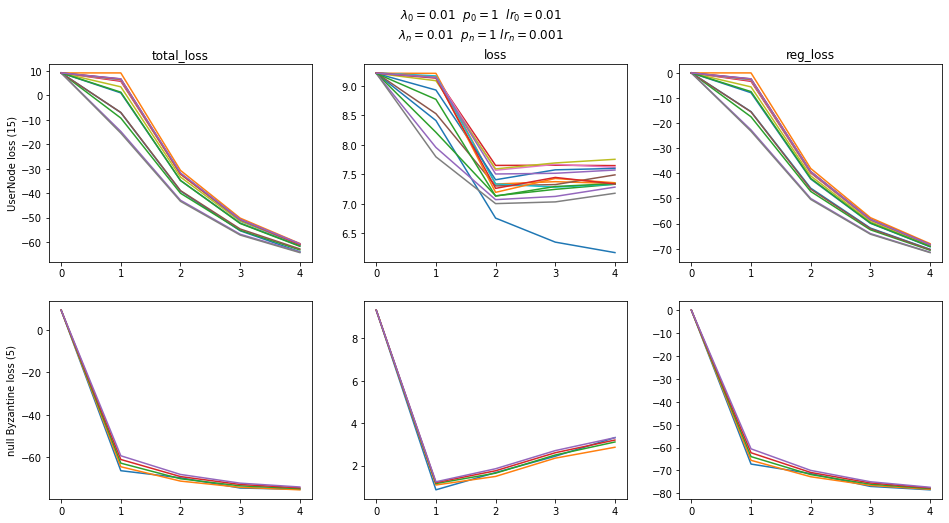

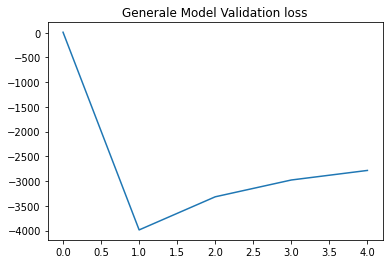

In [3]:
federated.train(5)

In [2]:
from src.federated_pipeline import Federated_LICCHAVI

In [3]:
federated = Federated_LICCHAVI(
    "CONFIG_MODEL_WIKI.json",
    "CONFIG_FEDERATED_WIKI.json"
)

100%|██████████| 28/28 [00:00<00:00, 1125.64it/s]

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
No path given, please enter a path to load the model.



100%|██████████| 1000/1000 [00:00<00:00, 9611.21it/s]


100%|██████████| 5/5 [00:00<00:00, 67.23it/s]


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
No path given, please enter a path to load the model.


100%|██████████| 6/6 [00:00<00:00, 133.37it/s]

100%|██████████| 7/7 [00:00<00:00, 141.41it/s]

100%|██████████| 1/1 [00:00<00:00, 140.16it/s]

100%|██████████| 3/3 [00:00<00:00, 141.22it/s]

100%|██████████| 4/4 [00:00<00:00, 111.57it/s]

100%|██████████| 4/4 [00:00<00:00, 123.50it/s]

100%|██████████| 2/2 [00:00<00:00, 147.05it/s]

100%|██████████| 31/31 [00:00<00:00, 156.98it/s]

 10%|█         | 2/20 [00:00<00:03,  4.82it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


 20%|██        | 4/20 [00:01<00:04,  3.89it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


 35%|███▌      | 7/20 [00:02<00:04,  3.17it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


  5%|▌         | 1/20 [00:00<00:04,  4.52it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


 10%|█         | 2/20 [00:00<00:05,  3.37it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0


 20%|██        | 4/20 [00:01<00:04,  3.57it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 512.0


 25%|██▌       | 5/20 [00:01<00:04,  3.40it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 256.0


 35%|███▌      | 7/20 [00:02<00:04,  2.87it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 128.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 64.0


 80%|████████  | 16/20 [00:05<00:01,  2.52it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16.0


100%|██████████| 174/174 [00:01<00:00, 148.15it/s]


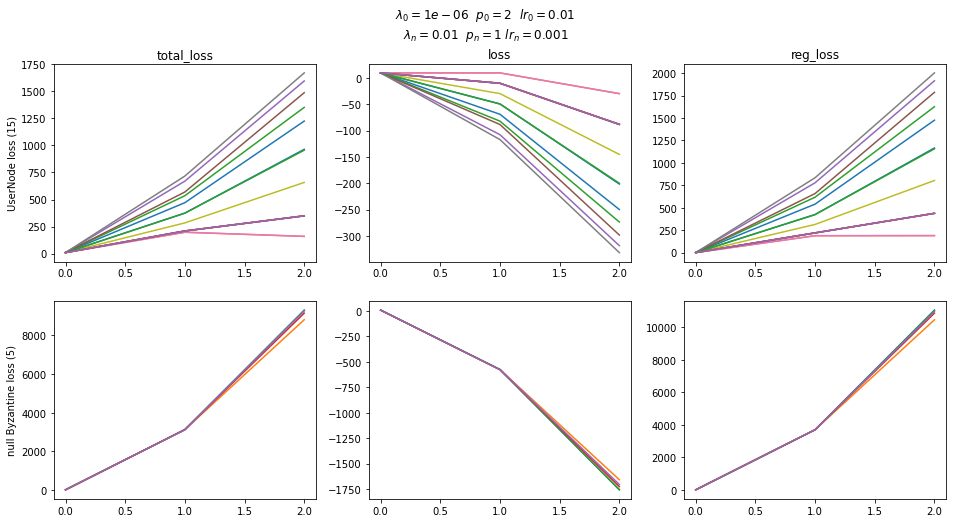

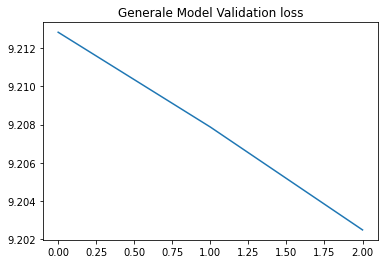

In [4]:
federated.train(2)